# E1: Domain Adaptation Extension

**Research Question:** Does the AskQE metric maintain its performance and stability when transitioned from medical and covid domain to a highly technical legal domain?

### **Overview**
This extension explores the behavior of AskQE using a specialized legal dataset. While the original framework was tested on informative/narrative corpora (like Wikipedia), legal texts present unique challenges: high lexical overlap, rigid terminology, and complex conditional logic (e.g., "unless otherwise provided").<br><br>

###**Dataset Source & Generation**
The evaluation is conducted on the **OPUS-DGT** corpus, which contains official documents of the Directorate-General for Translation of the European Commission.

* **Source Reference:** > Jorg Tiedemann. "Parallel Data, Tools and Interfaces in OPUS." In Proceedings of the Eighth International Conference on Language Resources and Evaluation (LREC'12), Istanbul, Turkey, 2012.




## 0. Setup

In [1]:
!pip install deep_translator
!pip install sacrebleu
!pip install bert_score
!pip install unbabel-comet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [3]:
!git clone -b domain-adaptation-ext https://github.com/AlessandroMaini/CucumBERT_askqe.git

Cloning into 'CucumBERT_askqe'...
remote: Enumerating objects: 2543, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 2543 (delta 29), reused 36 (delta 17), pack-reused 2484 (from 2)
Receiving objects: 100% (2543/2543), 65.27 MiB | 20.01 MiB/s, done.
Resolving deltas: 100% (1771/1771), done.


## 1. Legal Domain Analytics

We focus on understanding the main features of the new legal dataset, throught useful insights.

In [2]:
import json
import os
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import random
import string # Import string for punctuation

# Download necessary NLTK data (if not already downloaded)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

def load_data(filepath):
    """Loads data from a .jsonl file."""
    data = []
    if not os.path.exists(filepath):
        print(f"Warning: File not found at {filepath}")
        return data
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from line: {line.strip()} - {e}")
    return data

def analyze_text_field(texts, field_name):
    """Analyzes a list of texts for word/token counts and sentence counts."""
    total_words = 0  # Words without punctuation
    total_tokens = 0 # Tokens including punctuation
    total_sentences = 0
    total_entries = len(texts)

    if not texts: # Handle empty list
        return {
            'average_words_per_entry': 0,
            'average_tokens_per_entry': 0,
            'average_sentences_per_entry': 0,
            'total_entries': 0
        }

    for text in texts:
        sentences = sent_tokenize(text)
        total_sentences += len(sentences)
        for sentence in sentences:
            # Tokenize the sentence
            tokens_in_sentence = word_tokenize(sentence)
            total_tokens += len(tokens_in_sentence)

            # Count words by filtering out punctuation from tokens
            words_in_sentence = [token for token in tokens_in_sentence if token not in string.punctuation]
            total_words += len(words_in_sentence)

    avg_words_per_entry = total_words / total_entries
    avg_tokens_per_entry = total_tokens / total_entries
    avg_sentences_per_entry = total_sentences / total_entries

    return {
        'average_words_per_entry': avg_words_per_entry,
        'average_tokens_per_entry': avg_tokens_per_entry,
        'average_sentences_per_entry': avg_sentences_per_entry,
        'total_entries': total_entries
    }

def print_random_samples(data, num_samples=3):
    """Prints random samples from the dataset."""
    if not data:
        print("No data available for sampling.")
        return

    print(f"\n--- Random Samples ({min(num_samples, len(data))} of {len(data)}) ---")
    samples = random.sample(data, min(num_samples, len(data)))
    for i, entry in enumerate(samples):
        print(f"\nSample {i+1}:")
        for key, value in entry.items():
            print(f"  {key}: {value}")


# Dataset paths
dataset_paths = {
    "en-es": "/content/CucumBERT_askqe/data/processed/en-es.jsonl",
    "en-fr": "/content/CucumBERT_askqe/data/processed/en-fr.jsonl"
}

print("### Dataset Insights ###")

for name, path in dataset_paths.items():
    print(f"\nAnalyzing dataset: {name} ({path})")
    dataset = load_data(path)

    if not dataset:
        print(f"No data loaded for {name}. Skipping analysis.")
        continue

    src_lang = name.split('-')[0]
    target_lang = name.split('-')[1]

    original_texts = [entry[src_lang] for entry in dataset if src_lang in entry]
    mt_texts = [entry[target_lang] for entry in dataset if target_lang in entry]

    print("\n--- Original Text Statistics (English) ---")
    stats_original = analyze_text_field(original_texts, 'original_text')
    print(f"Total entries: {stats_original['total_entries']}")
    print(f"Average words per original entry: {stats_original['average_words_per_entry']:.2f}")
    print(f"Average tokens per original entry: {stats_original['average_tokens_per_entry']:.2f}")
    print(f"Average sentences per original entry: {stats_original['average_sentences_per_entry']:.2f}")

    print("\n--- Translation Statistics ---")
    stats_mt = analyze_text_field(mt_texts, 'machine_translation')
    print(f"Total entries: {stats_mt['total_entries']}")
    print(f"Average words per MT entry: {stats_mt['average_words_per_entry']:.2f}")
    print(f"Average tokens per MT entry: {stats_mt['average_tokens_per_entry']:.2f}")
    print(f"Average sentences per MT entry: {stats_mt['average_sentences_per_entry']:.2f}")

    # Print random samples
    print_random_samples(dataset, num_samples=3)

print("\n### Analysis Complete ###")

### Dataset Insights ###

Analyzing dataset: en-es (/content/CucumBERT_askqe/data/processed/en-es.jsonl)

--- Original Text Statistics (English) ---
Total entries: 500
Average words per original entry: 22.75
Average tokens per original entry: 25.12
Average sentences per original entry: 1.00

--- Translation Statistics ---
Total entries: 500
Average words per MT entry: 25.80
Average tokens per MT entry: 28.08
Average sentences per MT entry: 1.03

--- Random Samples (3 of 500) ---

Sample 1:
  id: 198
  en: the Agreement signed on 25 June 1991 on the Accession of the Portuguese Republic:
  es: el Acuerdo de Adhesión de la República Portuguesa firmado el 25 de junio de 1991:

Sample 2:
  id: 250
  en: in Romania, in the area of Podișul Transilvaniei’.
  es: en Rumanía: la zona de Podișul Transilvaniei».

Sample 3:
  id: 118
  en: No extensions shall be granted for the contracting period.
  es: No se concederán prórrogas del período de contratación.

Analyzing dataset: en-fr (/content/Cucu

## 2 Extension Evaluation — E1 (Domain Adaptation)

We evaluate whether AskQE's ability to assess translation considering the new domain on two axes:

1. **Instance-level Pearson correlation** between AskQE metrics and standard MT metrics (xCOMET, BT-Score).
2. **Silhouette score** — how well AskQE metrics separate **critical** (omission, alteration) from **minor** (synonym, expansion) perturbations.

SBERT

In [3]:
import os

os.chdir("/content/CucumBERT_askqe/evaluation/sbert")
!python sbert.py --model "qwen3-4b" --output_file "evaluation/sbert/qwen3-4b.csv"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
tokenizer_config.json: 100% 350/350 [00:00<00:00, 3.15MB/s]
vocab.txt: 232kB [00:00, 26.3MB/s]
tokenizer.json: 466kB [00:00, 50.8MB/s]
special_tokens_map.json: 100% 112/112 [00:00<00:00, 1.17MB/s]
config.json: 100% 612/612 [00:00<00:00, 6.19MB/s]
2026-02-13 08:24:17.853207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770971057.875455    1847 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770971057.882269    1847 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770971057.899509    1847 computation_placer.cc:177] computation pl

String Comparison

In [4]:
import os

os.chdir("/content/CucumBERT_askqe/evaluation/string-comparison")
!python string_comparison.py --model "qwen3-4b"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Processing: es | vanilla | alteration
Saved results to: /content/CucumBERT_askqe/evaluation/string-comparison/en-es/vanilla/alteration.jsonl
--------------------------------------------------------------------------------
Processing: es | vanilla | expansion_noimpact
Saved results to: /content/CucumBERT_askqe/evaluation/string-comparison/en-es/vanilla/expansion_noimpact.jsonl
--------------------------------------------------------------------------------
Processing: es | vanilla | omission
Saved results to: /content/CucumBERT_askqe/evaluation/string-comparison/en-es/vanilla/omission.jsonl
--------------------------------------------------------------------------------
Processing: es | vanilla | synonym
Saved results to: /content/CucumBERT_askqe/evaluation/string-comparison/en-es/vanilla/synonym.jsonl
--------------------------------------------------------------------------------


In [5]:
# Generate averaged string comparison metrics for atomic and vanilla pipelines
import json
import os

def calculate_average_metrics(file_path):
    total_f1 = 0
    total_em = 0
    total_chrf = 0
    total_bleu = 0
    num_comparisons = 0

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}. Skipping.")
        return None

    with open(file_path, 'r', encoding='utf-8') as f_in:
        for line in f_in:
            try:
                record = json.loads(line)
                for score_entry in record.get('scores', []):
                    total_f1 += score_entry.get('f1', 0)
                    total_em += score_entry.get('em', 0)
                    total_chrf += score_entry.get('chrf', 0)
                    total_bleu += score_entry.get('bleu', 0)
                    num_comparisons += 1
            except json.JSONDecodeError:
                continue

    if num_comparisons == 0:
        return None

    return {
        'f1': total_f1 / num_comparisons,
        'em': total_em / num_comparisons,
        'chrf': total_chrf / num_comparisons,
        'bleu': total_bleu / num_comparisons,
        'num_comparisons': num_comparisons
    }

languages = ["es"]
perturbations = ["alteration", "synonym", "expansion_noimpact", "omission"]
# Filtered pipelines
pipelines = ['vanilla', 'atomic']
output_root = "/content/CucumBERT_askqe/evaluation/string-comparison"

print("\n--- Averaged String Comparison Metrics (Vanilla & Atomic) ---")

for language in languages:
    for perturbation in perturbations:
        for pipeline in pipelines:
            # Construct path directly since we no longer need variants
            jsonl_output_file = os.path.join(output_root, f"en-{language}", pipeline, f"{perturbation}.jsonl")

            avg_metrics = calculate_average_metrics(jsonl_output_file)

            if avg_metrics:
                print(f"\nLanguage: {language}, Perturbation: {perturbation}, Pipeline: {pipeline}")
                print(f"  Average F1: {avg_metrics['f1']:.4f}")
                print(f"  Average EM: {avg_metrics['em']:.4f}")
                print(f"  Average chrF: {avg_metrics['chrf']:.4f}")
                print(f"  Average BLEU: {avg_metrics['bleu']:.4f}")
                print(f"  Number of comparisons: {avg_metrics['num_comparisons']}")
            else:
                # Optional: silence this if you don't want to see missing file logs
                print(f"\nNo data found for {language} | {perturbation} | {pipeline}")

print("\n--- End of Metrics ---")


--- Averaged String Comparison Metrics (Vanilla & Atomic) ---

Language: es, Perturbation: alteration, Pipeline: vanilla
  Average F1: 0.5818
  Average EM: 0.2783
  Average chrF: 60.9386
  Average BLEU: 43.6936
  Number of comparisons: 2113

Language: es, Perturbation: alteration, Pipeline: atomic
  Average F1: 0.5540
  Average EM: 0.2304
  Average chrF: 56.8813
  Average BLEU: 40.2661
  Number of comparisons: 946

Language: es, Perturbation: synonym, Pipeline: vanilla
  Average F1: 0.6700
  Average EM: 0.3209
  Average chrF: 67.9526
  Average BLEU: 50.9462
  Number of comparisons: 2138

Language: es, Perturbation: synonym, Pipeline: atomic
  Average F1: 0.7215
  Average EM: 0.3499
  Average chrF: 72.2509
  Average BLEU: 54.8505
  Number of comparisons: 986

Language: es, Perturbation: expansion_noimpact, Pipeline: vanilla
  Average F1: 0.6866
  Average EM: 0.2964
  Average chrF: 70.4796
  Average BLEU: 49.9329
  Number of comparisons: 2139

Language: es, Perturbation: expansion_noimp

Xcomet (Classic MT)

In [6]:
# Hugging Face Login
import huggingface_hub
huggingface_hub.login()

In [ ]:
os.chdir("/content/CucumBERT_askqe/evaluation/xcomet")
!python xcomet.py

2026-02-13 09:41:15.537480: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-13 09:41:15.542414: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-13 09:41:15.556923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770975675.580832    1229 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770975675.588002    1229 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770975675.606045    1229 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
import json
import os

# Average COMET segment scores

def calculate_average_comet_score(file_path):
    total_score = 0
    num_samples = 0

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}. Skipping.")
        return None

    with open(file_path, 'r', encoding='utf-8') as f_in:
        for line in f_in:
            record = json.loads(line)
            if 'xcomet_annotation' in record and 'segment_score' in record['xcomet_annotation']:
                total_score += record['xcomet_annotation']['segment_score']
                num_samples += 1

    if num_samples == 0:
        return None

    return total_score / num_samples


languages = ["es"]
perturbations = ["alteration", "synonym", "expansion_noimpact", "omission"]

print("\n--- Average COMET Segment Scores ---")

for language in languages:
    for perturbation in perturbations:
        comet_file = f"/content/CucumBERT_askqe/evaluation/xcomet/en-{language}/{perturbation}.jsonl"
        avg_score = calculate_average_comet_score(comet_file)

        if avg_score is not None:
            print(f"\nLanguage: {language}, Perturbation: {perturbation}")
            print(f"  Average COMET Segment Score: {avg_score:.4f}")
        else:
            print(f"\nNo COMET scores found for {language}-{perturbation}")

print("\n--- End of COMET Scores ---")

Bert score (classic MT)

In [9]:
os.chdir("/content/CucumBERT_askqe/evaluation/bt-score")
!python bt_score.py

Processing - Language: es, Perturbation: synonym
Running BERTScore on 500 samples...
tokenizer_config.json: 100% 52.0/52.0 [00:00<00:00, 298kB/s]
config.json: 100% 792/792 [00:00<00:00, 7.78MB/s]
vocab.json: 899kB [00:00, 40.6MB/s]
merges.txt: 456kB [00:00, 157MB/s]
2026-02-13 08:36:49.933194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770971809.954252    5307 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770971809.961390    5307 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770971809.990115    5307 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than o

In [10]:
import json
import os

def calculate_average_bertscore(file_path):
    total_score = 0
    num_samples = 0

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}. Skipping.")
        return None

    with open(file_path, 'r', encoding='utf-8') as f_in:
        for line in f_in:
            try:
                record = json.loads(line)
                # target the flat key 'bertscore_f1' instead of nested xcomet structure
                if 'bertscore_f1' in record:
                    total_score += record['bertscore_f1']
                    num_samples += 1
            except json.JSONDecodeError:
                continue

    if num_samples == 0:
        return None

    return total_score / num_samples

languages = ["es"]
perturbations = ["alteration", "synonym", "expansion_noimpact", "omission"]

print("\n--- Average BERTScore F1 ---")

for language in languages:
    for perturbation in perturbations:
        base_dir = f"/content/CucumBERT_askqe/evaluation/bt-score/en-{language}"
        filename = f"bt-{perturbation}_bertscore.jsonl"
        file_path = os.path.join(base_dir, filename)

        avg_score = calculate_average_bertscore(file_path)

        if avg_score is not None:
            print(f"\nLanguage: {language}, Perturbation: {perturbation}")
            print(f"  Average BERTScore F1: {avg_score:.4f}")
        else:
            # This is normal if you haven't generated the 'synonym' file yet
            print(f"\nNo BERTScore data found for {filename}")

print("\n--- End of Scores ---")


--- Average BERTScore F1 ---

Language: es, Perturbation: alteration
  Average BERTScore F1: 0.8704

Language: es, Perturbation: synonym
  Average BERTScore F1: 0.9019

Language: es, Perturbation: expansion_noimpact
  Average BERTScore F1: 0.8979

Language: es, Perturbation: omission
  Average BERTScore F1: 0.8708

--- End of Scores ---


Pearson Correlation

In [11]:
os.chdir("/content/CucumBERT_askqe/evaluation/pearson-correlation")
!python compute_correlation.py --dataset en-es

Loading standard metric: xcomet
  1996 instances loaded
Loading standard metric: bt_score
  1996 instances loaded
Loading AskQE metric: f1-vanilla
  1968 instances loaded
Loading AskQE metric: f1-atomic
  1910 instances loaded
Loading AskQE metric: em-vanilla
  1968 instances loaded
Loading AskQE metric: em-atomic
  1910 instances loaded
Loading AskQE metric: bleu-vanilla
  1968 instances loaded
Loading AskQE metric: bleu-atomic
  1910 instances loaded
Loading AskQE metric: chrf-vanilla
  1968 instances loaded
Loading AskQE metric: chrf-atomic
  1910 instances loaded
Loading AskQE metric: sbert-vanilla
  1968 instances loaded
Loading AskQE metric: sbert-atomic
  1910 instances loaded

DATASET: en-es

Per-perturbation averages (standard):
        xcomet | synonym: 0.8665  alteration: 0.7549  omission: 0.7840  expansion_noimpact: 0.8513
      bt_score | synonym: 0.9019  alteration: 0.8704  omission: 0.8707  expansion_noimpact: 0.8978

Per-perturbation averages (AskQE):
            f1-van

In [12]:
## DISPLAY PEARSON CORRELATION (uncomment) ##
!python plot_instance_correlation.py

Saved: /content/CucumBERT_askqe/evaluation/pearson-correlation/plots/heatmap_instance_en-es.png

All heatmaps saved to: /content/CucumBERT_askqe/evaluation/pearson-correlation/plots


Silhouette

In [13]:
## COMPUTE Silhouette score ##
os.chdir("/content/CucumBERT_askqe/evaluation/silhouette")
!python silhouette_score.py --target-lang en-es --plot


Processing pipeline: vanilla
  Loaded 493 items from omission
  Loaded 485 items from alteration
  Loaded 495 items from synonym
  Loaded 495 items from expansion_noimpact
  SBERT        silhouette=0.028441  (n=1968)
    KDE plot saved to /content/CucumBERT_askqe/evaluation/silhouette/plots/kde_sbert_vanilla_en-es.png
  F1           silhouette=0.027491  (n=1968)
    KDE plot saved to /content/CucumBERT_askqe/evaluation/silhouette/plots/kde_f1_vanilla_en-es.png
  EM           silhouette=0.003856  (n=1968)
    KDE plot saved to /content/CucumBERT_askqe/evaluation/silhouette/plots/kde_em_vanilla_en-es.png
  CHRF         silhouette=0.028476  (n=1968)
    KDE plot saved to /content/CucumBERT_askqe/evaluation/silhouette/plots/kde_chrf_vanilla_en-es.png
  BLEU         silhouette=0.011586  (n=1968)
    KDE plot saved to /content/CucumBERT_askqe/evaluation/silhouette/plots/kde_bleu_vanilla_en-es.png

Processing pipeline: atomic
  Loaded 482 items from omission
  Loaded 455 items from alteratio

In [14]:
## DISPLAY SILHOUETTE (uncomment) ##
!python display_results.py "evaluation/silhouette/results_en-es.json" --compare


Results for: en-es

Critical Perturbations: omission, alteration
Minimal Perturbations: synonym, expansion_noimpact

------------------------------------------------------------
Pipeline: vanilla  (AskQE metrics)
------------------------------------------------------------

  Metric         Silhouette        N
  ----------------------------------
  SBERT            0.028441     1968
  F1               0.027491     1968
  EM               0.003856     1968
  CHRF             0.028476     1968
  BLEU             0.011586     1968

------------------------------------------------------------
Pipeline: atomic  (AskQE metrics)
------------------------------------------------------------

  Metric         Silhouette        N
  ----------------------------------
  SBERT            0.025770     1910
  F1               0.039664     1910
  EM               0.007484     1910
  CHRF             0.032835     1910
  BLEU             0.017670     1910

-----------------------------------------------

Smerdate varie

In [15]:
import os

xcomet_scores = {}
perturbations = ['alteration', 'synonym', 'expansion_noimpact', 'omission']

base_dir = '/content/CucumBERT_askqe/evaluation/xcomet/en-es'

print("### Loading XCOMET Data ###")

for perturbation in perturbations:
    file_path = os.path.join(base_dir, f"{perturbation}.jsonl")
    avg_score = calculate_average_comet_score(file_path)

    if avg_score is not None:
        xcomet_scores[perturbation] = avg_score
        print(f"Loaded average XCOMET score for {perturbation}: {avg_score:.4f}")
    else:
        print(f"No XCOMET data found for {perturbation} at {file_path}")

print("\nAll XCOMET scores loaded:")
for pert, score in xcomet_scores.items():
    print(f"  {pert}: {score:.4f}")

### Loading XCOMET Data ###
Loaded average XCOMET score for alteration: 0.7545
Loaded average XCOMET score for synonym: 0.8665
Loaded average XCOMET score for expansion_noimpact: 0.8513
Loaded average XCOMET score for omission: 0.7838

All XCOMET scores loaded:
  alteration: 0.7545
  synonym: 0.8665
  expansion_noimpact: 0.8513
  omission: 0.7838


In [16]:
bt_scores = {}
perturbations = ['alteration', 'synonym', 'expansion_noimpact', 'omission']

base_dir = '/content/CucumBERT_askqe/evaluation/bt-score/en-es'

print("### Loading BT-Score Data ###")

for perturbation in perturbations:
    file_path = os.path.join(base_dir, f"bt-{perturbation}_bertscore.jsonl")
    avg_score = calculate_average_bertscore(file_path)

    if avg_score is not None:
        bt_scores[perturbation] = avg_score
        print(f"Loaded average BT-Score for {perturbation}: {avg_score:.4f}")
    else:
        print(f"No BT-Score data found for {perturbation} at {file_path}")

print("\nAll BT-Score scores loaded:")
for pert, score in bt_scores.items():
    print(f"  {pert}: {score:.4f}")

### Loading BT-Score Data ###
Loaded average BT-Score for alteration: 0.8704
Loaded average BT-Score for synonym: 0.9019
Loaded average BT-Score for expansion_noimpact: 0.8979
Loaded average BT-Score for omission: 0.8708

All BT-Score scores loaded:
  alteration: 0.8704
  synonym: 0.9019
  expansion_noimpact: 0.8979
  omission: 0.8708


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create lists for DataFrame construction
perturbations_list = list(xcomet_scores.keys())
xcomet_values = [xcomet_scores[p] for p in perturbations_list]
bt_score_values = [bt_scores[p] for p in perturbations_list]

# Create DataFrame
data = {
    'Perturbation': perturbations_list,
    'XCOMET': xcomet_values,
    'BT-Score': bt_score_values
}
df_metrics = pd.DataFrame(data)

print("### Combined Metrics DataFrame ###")
print(df_metrics)


### Combined Metrics DataFrame ###
         Perturbation    XCOMET  BT-Score
0          alteration  0.754494  0.870391
1             synonym  0.866500  0.901907
2  expansion_noimpact  0.851250  0.897866
3            omission  0.783800  0.870751


Bar chart saved to: /content/CucumBERT_askqe/evaluation/plots/xcomet_btscore_comparison_bar_chart.png


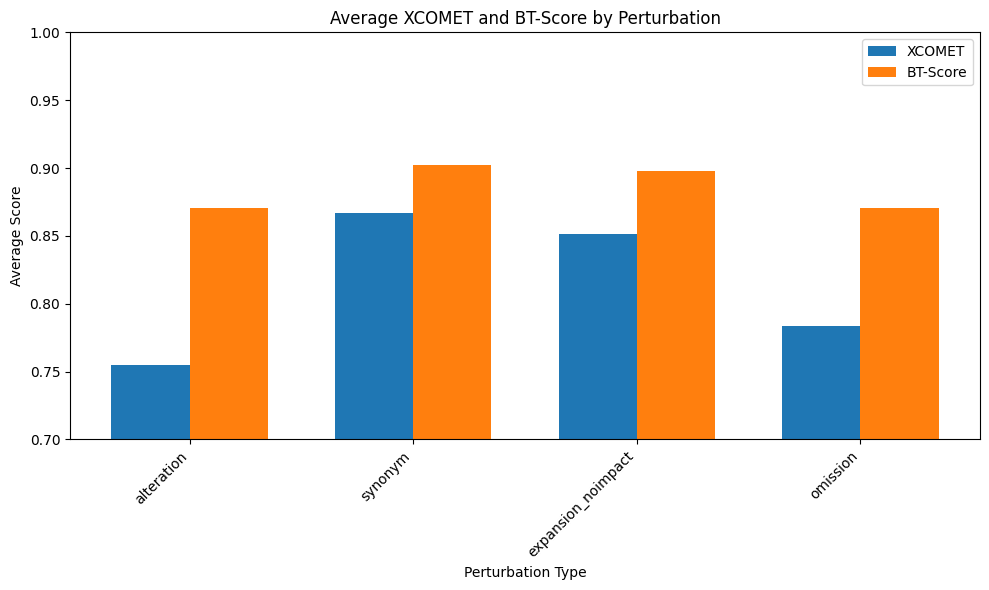

In [18]:
bar_width = 0.35
r = np.arange(len(df_metrics['Perturbation']))

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(r - bar_width/2, df_metrics['XCOMET'], bar_width, label='XCOMET')
bars2 = ax.bar(r + bar_width/2, df_metrics['BT-Score'], bar_width, label='BT-Score')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Perturbation Type')
ax.set_ylabel('Average Score')
ax.set_title('Average XCOMET and BT-Score by Perturbation')
ax.set_xticks(r)
ax.set_xticklabels(df_metrics['Perturbation'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0.7, 1.0) # Set a reasonable y-limit for scores

plt.tight_layout()

# Create the directory if it doesn't exist
output_dir = '/content/CucumBERT_askqe/evaluation/plots/'
os.makedirs(output_dir, exist_ok=True)

# Save the plot
plot_path = os.path.join(output_dir, 'xcomet_btscore_comparison_bar_chart.png')
plt.savefig(plot_path)

print(f"Bar chart saved to: {plot_path}")
plt.show()

aske strings

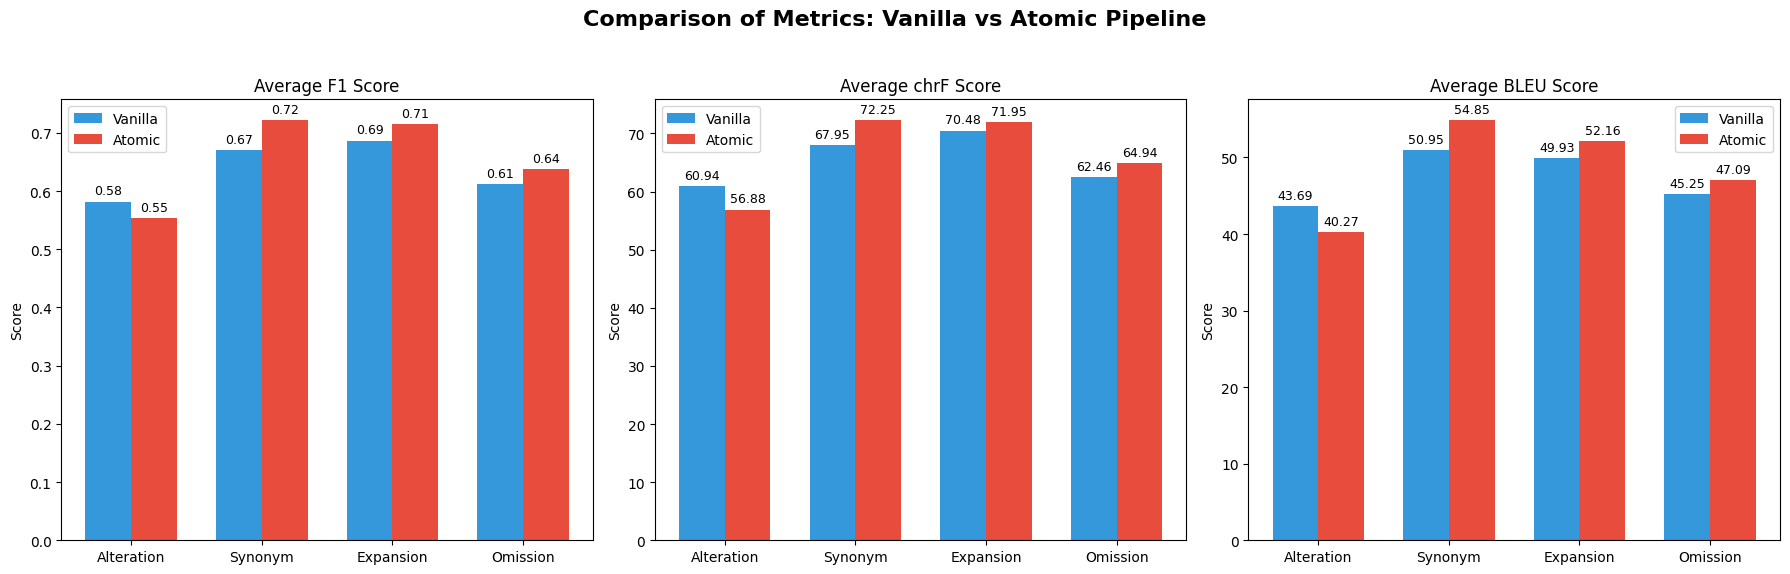

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data Preparation
data = {
    'Perturbation': ['Alteration', 'Synonym', 'Expansion', 'Omission'],
    'Vanilla_F1': [0.5818, 0.6700, 0.6866, 0.6115],
    'Atomic_F1': [0.5540, 0.7215, 0.7146, 0.6375],
    'Vanilla_chrF': [60.9386, 67.9526, 70.4796, 62.4622],
    'Atomic_chrF': [56.8813, 72.2509, 71.9455, 64.9435],
    'Vanilla_BLEU': [43.6936, 50.9462, 49.9329, 45.2545],
    'Atomic_BLEU': [40.2661, 54.8505, 52.1650, 47.0903]
}

df = pd.DataFrame(data)

# Setting up the figure with 3 subplots for F1, chrF, and BLEU
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparison of Metrics: Vanilla vs Atomic Pipeline', fontsize=16, fontweight='bold')

metrics = ['F1', 'chrF', 'BLEU']
colors = ['#3498db', '#e74c3c'] # Blue for Vanilla, Red for Atomic

x = np.arange(len(df['Perturbation']))
width = 0.35

for i, metric in enumerate(metrics):
    vanilla_col = f'Vanilla_{metric}'
    atomic_col = f'Atomic_{metric}'

    rects1 = axes[i].bar(x - width/2, df[vanilla_col], width, label='Vanilla', color=colors[0])
    rects2 = axes[i].bar(x + width/2, df[atomic_col], width, label='Atomic', color=colors[1])

    axes[i].set_title(f'Average {metric} Score')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(df['Perturbation'])
    axes[i].set_ylabel('Score')
    axes[i].legend()

    # Add values on top of bars
    def autolabel(rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1, axes[i])
    autolabel(rects2, axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('vanilla_vs_atomic_metrics.png')
plt.show()